# Prediction Results on Summary Vectronics Data

**Last Modified**: Aug 20, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, field
from typing import  List

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (setup_dataloaders,)

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleNN)

from src.utils.io import (get_metadata_path,
                          get_results_dir,

                          )
from src.utils import preprocess
import src.utils.io as io
from src.utils.Vectronics_preprocessing import (load_annotations,
                                                load_Vectronics_data_metadata,
                                                create_max_windows,
                                                create_data_splits,
                                                create_summary_data)
from src.utils.functionalities import(mmd_test,
                                      median_pairwise_distance,
                                      set_seed)
import config as config
from sklearn.model_selection import train_test_split

In [3]:
# Graphing Parameters
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [4]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = load_annotations()

In [5]:
values = [10, 20, 30]
quantiles = [np.mean(all_annotations["duration"] <= value) for value in values]
for value, q in zip(values, quantiles):
    print(f"Value {value}s is approximately at the {q:.2f}th percentile.")

Value 10s is approximately at the 0.53th percentile.
Value 20s is approximately at the 0.71th percentile.
Value 30s is approximately at the 0.79th percentile.


In [6]:
# Group and sum durations in hours
duration_table = np.round(all_annotations.groupby(['Source', 'Behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR ANNOTATIONS
Behavior  Feeding   Moving   Other  Running  Stationary
Source                                                 
Audio      2.7131   9.1328  0.0000   5.4644      0.0000
Video      1.4881   3.6972  1.2767   0.1722     80.8881
Total      4.2012  12.8300  1.2767   5.6366     80.8881


In [9]:
# load metadata, matched acceleration data, and matched acceleration metadata
metadata = pd.read_csv(get_metadata_path())
acc_data, acc_data_metadata = load_Vectronics_data_metadata()

# Group and sum durations in hours
duration_table = np.round(acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR MATCHED ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR MATCHED ANNOTATIONS
behavior  Feeding   Moving   Other  Running  Stationary
Source                                                 
Audio      2.7085   9.0802  0.0000   5.3635      0.0000
Video      1.3184   1.6700  1.0506   0.0936     68.0157
Total      4.0269  10.7502  1.0506   5.4571     68.0157


In [10]:
annotations_summary = pd.read_csv(io.get_matched_annotations_summary_path())
unmatched_audio_labels_duration = annotations_summary[(annotations_summary.match == 0) & (annotations_summary.Source == 'Audio')].dropna().duration.sum()/3600
print(f"TOTAL UNMATCHED AUDIO LABELS: {unmatched_audio_labels_duration} hours")

TOTAL UNMATCHED AUDIO LABELS: 0.11 hours


## 1. Create $X$: Summarize the Vectronics Matched Data

In [11]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
feature_cols = Vectronics_preprocessing_config['feature_cols']
helper_cols = Vectronics_preprocessing_config['helper_cols']

First, we see if the distribution of summaries varies when the summaries are calculated over 20 seconds or 30 seconds windows of acceleration data.

In [15]:
window_durations = [20.0, 30.0]
datasets = []
# for instances > window duration, split them into multiple instances

for window_duration in window_durations:
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=config.SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

    # Group and sum durations in hours
    duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)
    duration_df = duration_table.unstack(fill_value=0)
    duration_df.loc['Total'] = duration_df.sum()

    print(f"Window duration = {window_duration}")
    print(duration_df)

    datasets.append(create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE))
    

Window duration = 20.0
behavior   Feeding    Moving     Other   Running  Stationary
Source                                                      
Audio     2.338889  6.822222  0.000000  4.005556    0.000000
Video     0.927778  0.466667  0.244444  0.038889   55.772222
Total     3.266667  7.288889  0.244444  4.044444   55.772222
Window duration = 30.0
behavior   Feeding  Moving  Other   Running  Stationary
Source                                                 
Audio     2.141667   5.525  0.000  3.291667    0.000000
Video     0.750000   0.225  0.175  0.016667   51.566667
Total     2.891667   5.750  0.175  3.308333   51.566667


In [16]:
from itertools import combinations

n, m = 5000, 5000
num_permutations = 100
seed = 42
rng = np.random.default_rng(seed)

datasets = {'window_20': datasets[0][feature_cols].values[rng.permutation(len(datasets[0]))],
            'window_30': datasets[1][feature_cols].values[rng.permutation(len(datasets[1]))]
}

for (name1, Xs), (name2, Xt) in combinations(datasets.items(), 2):
    Xs_sub = Xs[:n, :]
    Xt_sub = Xt[:m, :]
    
    sigma = median_pairwise_distance(Xs_sub, Xt_sub)
    stat, permuted_stat, pval = mmd_test(
        X=Xs_sub,
        Y=Xt_sub,
        sigma=sigma,
        num_permutations=num_permutations,
        seed=seed
    )
    
    print(f"\nComparison: {name1} vs {name2}")
    print(f"MMD² statistic: {stat:.4f}")
    if pval < 0.05:
        print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H₀).")
    else:
        print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H₀).")



Comparison: window_20 vs window_30
MMD² statistic: 0.0004
P-value: 0.0600 - The two distributions are not significantly different (fail to reject H₀).


Now we create summary datasets with different minimum matched duration.

In [49]:
from src.utils.data_prep import create_matched_data

min_windows_for_padding = [None, 15.0, 10.0]
datasets = {'duration_30_min_window_30': None,
            'duration_30_min_window_15': None,
            'duration_30_min_window_10': None,
}
window_duration = Vectronics_preprocessing_config['window_duration']

for window, name in zip(min_windows_for_padding, datasets.keys()):

    _, acc_data, acc_data_metadata, _ = create_matched_data(filtered_metadata=metadata, 
                                                            annotations=all_annotations, 
                                                            verbose=True, 
                                                            min_window_for_padding=window,
                                                            min_matched_duration=30.0)
    
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=config.SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]
    vectronics_df = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)
    datasets[name] = vectronics_df

individual jessie has 506 halfdays in the filtered metadata.


Processing unique half days for jessie: 100%|██████████| 506/506 [00:46<00:00, 11.00it/s]


individual green has 900 halfdays in the filtered metadata.


Processing unique half days for green: 100%|██████████| 900/900 [00:36<00:00, 24.55it/s]


individual palus has 744 halfdays in the filtered metadata.


Processing unique half days for palus: 100%|██████████| 744/744 [00:21<00:00, 34.38it/s]


individual ash has 792 halfdays in the filtered metadata.


Processing unique half days for ash: 100%|██████████| 792/792 [00:49<00:00, 16.10it/s]


individual fossey has 448 halfdays in the filtered metadata.


Processing unique half days for fossey: 100%|██████████| 448/448 [00:36<00:00, 12.39it/s]


individual jessie has 506 halfdays in the filtered metadata.


Processing unique half days for jessie: 100%|██████████| 506/506 [00:50<00:00,  9.98it/s]


individual green has 900 halfdays in the filtered metadata.


Processing unique half days for green: 100%|██████████| 900/900 [00:34<00:00, 25.77it/s]


individual palus has 744 halfdays in the filtered metadata.


Processing unique half days for palus: 100%|██████████| 744/744 [00:20<00:00, 36.79it/s]


individual ash has 792 halfdays in the filtered metadata.


Processing unique half days for ash: 100%|██████████| 792/792 [00:48<00:00, 16.47it/s]


individual fossey has 448 halfdays in the filtered metadata.


Processing unique half days for fossey: 100%|██████████| 448/448 [00:36<00:00, 12.13it/s]


individual jessie has 506 halfdays in the filtered metadata.


Processing unique half days for jessie: 100%|██████████| 506/506 [00:50<00:00, 10.10it/s]


individual green has 900 halfdays in the filtered metadata.


Processing unique half days for green: 100%|██████████| 900/900 [00:36<00:00, 24.46it/s]


individual palus has 744 halfdays in the filtered metadata.


Processing unique half days for palus: 100%|██████████| 744/744 [00:20<00:00, 35.66it/s]


individual ash has 792 halfdays in the filtered metadata.


Processing unique half days for ash: 100%|██████████| 792/792 [00:50<00:00, 15.58it/s]


individual fossey has 448 halfdays in the filtered metadata.


Processing unique half days for fossey: 100%|██████████| 448/448 [00:38<00:00, 11.64it/s]


In [27]:
# Load preprocessed Vectronics config

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)

Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']
Vectronics_helper_cols = Vectronics_preprocessing_config['helper_cols']
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path())
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

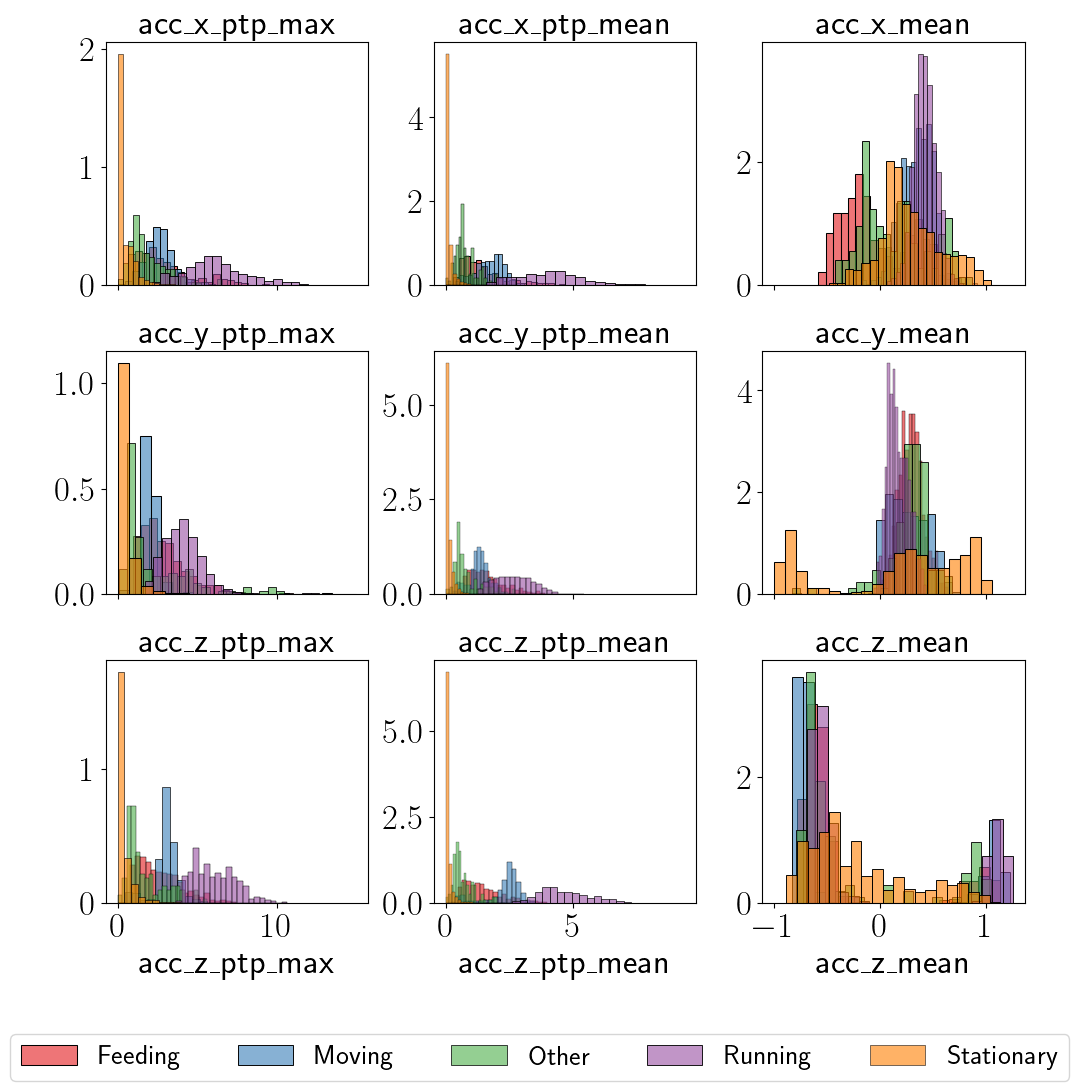

In [64]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(config.SUMMARY_BEHAVIORS))

behaviors_to_plot = vectronics_df['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(config.SUMMARY_BEHAVIORS):
            sns.histplot(
                vectronics_df[vectronics_df['behavior'] == behavior][feature],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=20,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_title(feature)
        ax.set_ylabel("")

# Place legend outside at the bottom center
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(config.SUMMARY_BEHAVIORS), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## 2. Predict $Y \mid X$: Train Classification Model

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

training_results_dir = os.path.join(get_results_dir(), 'summary_training_results')
os.makedirs(training_results_dir, exist_ok=True)

In [30]:
# train and model arguments

@dataclass
class TrainArgs:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False
    seed: int= 1

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [32, 64])
    dropout_rate: float = 0.5

train_args = TrainArgs()
model_args = ModelArgs()

In [ ]:
X = datasets[f'duration_{int(window_duration)}_min_window_{10}'][feature_cols].values
y = datasets[f'duration_{int(window_duration)}_min_window_{10}']['behavior'].values

y = label_encoder.fit_transform(y)

lows, highs = preprocess.compute_combined_quantiles(
            [X], pos_idx=[0, 1, 2, 3, 4, 5], center_idx=[6, 7, 8],
            low_q=0.00, high_q=1.0,
        )
X = preprocess.transform_and_scale(X, [0, 1, 2, 3, 4, 5], [6, 7, 8], lows, highs, clip_to_quantile=True)

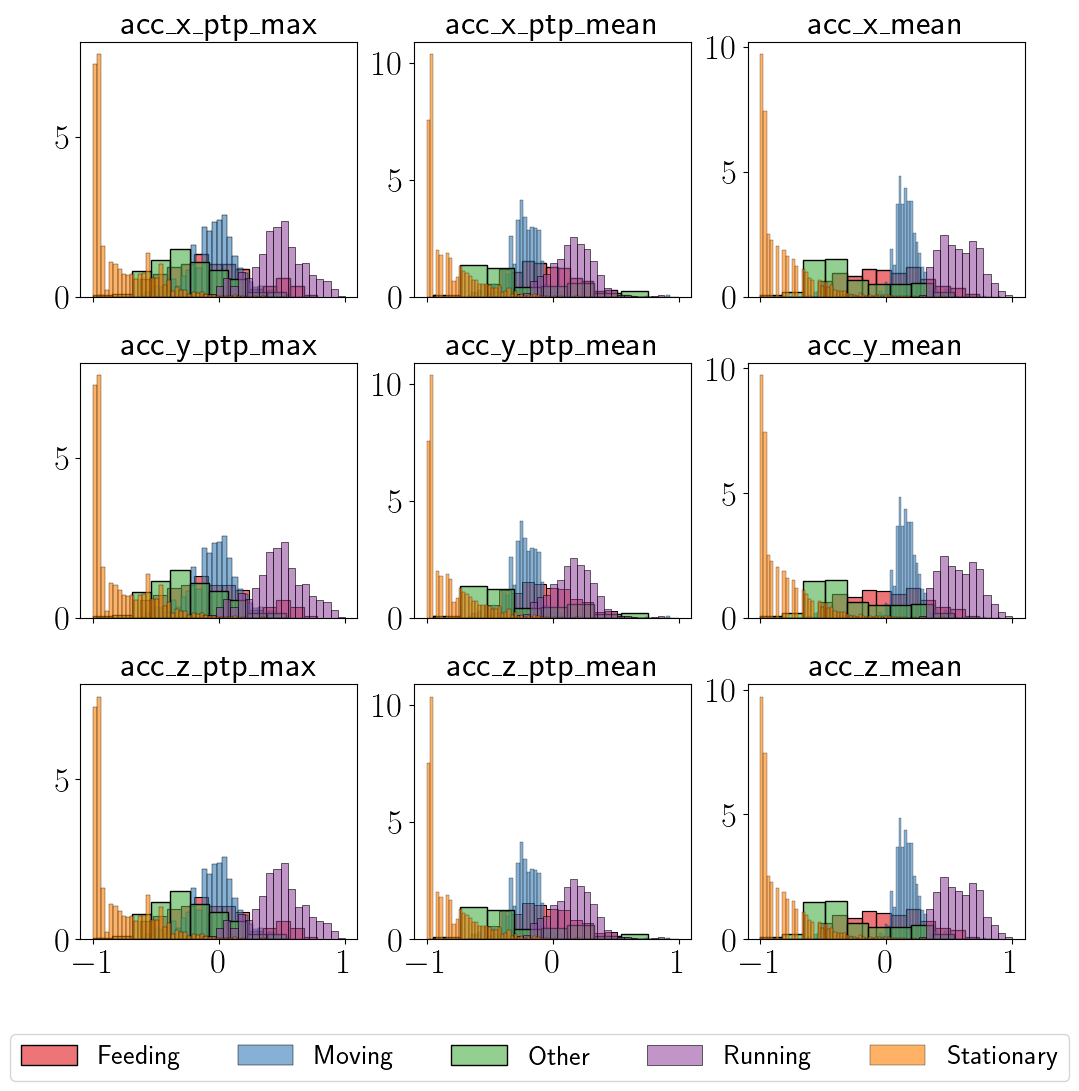

In [79]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(config.SUMMARY_BEHAVIORS))

behaviors_to_plot = vectronics_df['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(config.SUMMARY_BEHAVIORS):
            sns.histplot(
                X[y == k, j],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                # bins=20,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_title(feature)
        ax.set_ylabel("")

# Place legend outside at the bottom center
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(config.SUMMARY_BEHAVIORS), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

In [89]:
min_windows_for_padding = [30.0, 15.0, 10.0]

for duration in min_windows_for_padding:
    print(np.unique(datasets[f'duration_{int(window_duration)}_min_window_{int(duration)}']['behavior'], return_counts=True))


(array(['Feeding', 'Moving', 'Other', 'Running', 'Stationary'],
      dtype=object), array([ 347,  690,   21,  397, 6188]))
(array(['Feeding', 'Moving', 'Other', 'Running', 'Stationary'],
      dtype=object), array([ 423, 1023,   58,  532, 7063]))
(array(['Feeding', 'Moving', 'Other', 'Running', 'Stationary'],
      dtype=object), array([ 455, 1345,  113,  652, 7649]))


In [80]:
min_windows_for_padding = [30.0, 15.0, 10.0]
theta_list = np.round(0.1 * np.arange(11), 1)
seed_list = [1, 2, 3]

for duration in min_windows_for_padding:
    print(f"\nTraining with minimum matched duration before padding = {duration} seconds")

    # create train, val, and test splits

    X = datasets[f'duration_{int(window_duration)}_min_window_{int(duration)}'][feature_cols].values
    y = datasets[f'duration_{int(window_duration)}_min_window_{int(duration)}']['behavior'].values
    y = label_encoder.fit_transform(y)

    lows, highs = preprocess.compute_combined_quantiles(
                [X], pos_idx=[0, 1, 2, 3, 4, 5], center_idx=[6, 7, 8],
                low_q=0.00, high_q=1.0,
            )
    X = preprocess.transform_and_scale(X, [0, 1, 2, 3, 4, 5], [6, 7, 8], lows, highs, clip_to_quantile=True)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:", X_val.shape, "y_val:", y_val.shape)
    print("X_test:", X_test.shape, "y_test:", y_test.shape)

    for theta in tqdm(theta_list, desc="Training models for different theta values"):
        for seed in seed_list:

            tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
            train_args.theta = theta
            train_args.seed = seed

            set_seed(seed)

            # setup dataloaders
            train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

            # setup model, loss, and optimizer
            model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(config.SUMMARY_BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

            #### Training
            train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
            model = train_obj['model'].to(device)
            training_stats = train_obj['training_stats']

            model_dir = os.path.join(training_results_dir, f"duration{duration}_theta{train_args.theta}_seed{train_args.seed}")
            os.makedirs(model_dir, exist_ok=True)

            torch.save(model, os.path.join(model_dir, 'model.pt'))
            json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
            with open(json_training_stats_file, 'w') as f:
                json.dump(training_stats, f)

            # save true and predicted validation classes along with val metadata
            np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
            np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
            np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

            # save true and predicted validation classes along with val metadata
            np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
            np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
            np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
        


Training with minimum matched duration = 30.0 minutes
X_train: (4585, 9) y_train: (4585,)
X_val: (1529, 9) y_val: (1529,)
X_test: (1529, 9) y_test: (1529,)


Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0388 | Val Loss: 0.0224 | Best val Loss: 0.0224: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]
Training models for different theta values:   0%|          | 0/11 [00:09<?, ?it/s]

Total training time: 0:00:09
Current theta: 0.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.0442 | Val Loss: 0.0205 | Best val Loss: 0.0205: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]
Training models for different theta values:   0%|          | 0/11 [00:18<?, ?it/s]

Total training time: 0:00:09
Current theta: 0.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.0482 | Val Loss: 0.0224 | Best val Loss: 0.0224: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:26<04:20, 26.08s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0672 | Val Loss: 0.0231 | Best val Loss: 0.0231: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:33<04:20, 26.08s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 2


Epoch 100/100 | Train Loss: 0.0636 | Val Loss: 0.0228 | Best val Loss: 0.0224: 100%|██████████| 100/100 [00:08<00:00, 12.34it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:42<04:20, 26.08s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 3


Epoch 100/100 | Train Loss: 0.0696 | Val Loss: 0.0242 | Best val Loss: 0.0242: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:50<03:46, 25.19s/it]

Total training time: 0:00:09
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0782 | Val Loss: 0.0242 | Best val Loss: 0.0242: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:58<03:46, 25.19s/it]

Total training time: 0:00:08
Current theta: 0.2, Current seed: 2


Epoch 100/100 | Train Loss: 0.0726 | Val Loss: 0.0225 | Best val Loss: 0.0225: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:06<03:46, 25.19s/it]

Total training time: 0:00:08
Current theta: 0.2, Current seed: 3


Epoch 100/100 | Train Loss: 0.0794 | Val Loss: 0.0247 | Best val Loss: 0.0243: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:15<03:20, 25.06s/it]

Total training time: 0:00:09
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.0857 | Val Loss: 0.0244 | Best val Loss: 0.0244: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:23<03:20, 25.06s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 2


Epoch 100/100 | Train Loss: 0.0765 | Val Loss: 0.0223 | Best val Loss: 0.0223: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:32<03:20, 25.06s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 3


Epoch 100/100 | Train Loss: 0.0866 | Val Loss: 0.0240 | Best val Loss: 0.0238: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]
Training models for different theta values:  36%|███▋      | 4/11 [01:40<02:55, 25.13s/it]

Total training time: 0:00:09
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0957 | Val Loss: 0.0243 | Best val Loss: 0.0243: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]
Training models for different theta values:  36%|███▋      | 4/11 [01:48<02:55, 25.13s/it]

Total training time: 0:00:07
Current theta: 0.4, Current seed: 2


Epoch 100/100 | Train Loss: 0.0850 | Val Loss: 0.0235 | Best val Loss: 0.0233: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]
Training models for different theta values:  36%|███▋      | 4/11 [01:56<02:55, 25.13s/it]

Total training time: 0:00:08
Current theta: 0.4, Current seed: 3


Epoch 100/100 | Train Loss: 0.0928 | Val Loss: 0.0241 | Best val Loss: 0.0239: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:03<02:25, 24.17s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.0998 | Val Loss: 0.0261 | Best val Loss: 0.0261: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:11<02:25, 24.17s/it]

Total training time: 0:00:08
Current theta: 0.5, Current seed: 2


Epoch 100/100 | Train Loss: 0.0920 | Val Loss: 0.0240 | Best val Loss: 0.0240: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:19<02:25, 24.17s/it]

Total training time: 0:00:08
Current theta: 0.5, Current seed: 3


Epoch 100/100 | Train Loss: 0.0991 | Val Loss: 0.0262 | Best val Loss: 0.0256: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [02:27<02:01, 24.35s/it]

Total training time: 0:00:08
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.1032 | Val Loss: 0.0272 | Best val Loss: 0.0270: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [02:36<02:01, 24.35s/it]

Total training time: 0:00:08
Current theta: 0.6, Current seed: 2


Epoch 100/100 | Train Loss: 0.0948 | Val Loss: 0.0247 | Best val Loss: 0.0239: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [02:44<02:01, 24.35s/it]

Total training time: 0:00:08
Current theta: 0.6, Current seed: 3


Epoch 100/100 | Train Loss: 0.1009 | Val Loss: 0.0263 | Best val Loss: 0.0263: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [02:52<01:37, 24.25s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.0984 | Val Loss: 0.0279 | Best val Loss: 0.0279: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:00<01:37, 24.25s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 2


Epoch 100/100 | Train Loss: 0.1021 | Val Loss: 0.0268 | Best val Loss: 0.0259: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:07<01:37, 24.25s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 3


Epoch 100/100 | Train Loss: 0.1046 | Val Loss: 0.0281 | Best val Loss: 0.0272: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [03:16<01:12, 24.19s/it]

Total training time: 0:00:08
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.1044 | Val Loss: 0.0305 | Best val Loss: 0.0294: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [03:24<01:12, 24.19s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 2


Epoch 100/100 | Train Loss: 0.1054 | Val Loss: 0.0288 | Best val Loss: 0.0286: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [03:32<01:12, 24.19s/it]

Total training time: 0:00:08
Current theta: 0.8, Current seed: 3


Epoch 100/100 | Train Loss: 0.1055 | Val Loss: 0.0292 | Best val Loss: 0.0290: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [03:41<00:48, 24.46s/it]

Total training time: 0:00:08
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.1068 | Val Loss: 0.0315 | Best val Loss: 0.0302: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [03:49<00:48, 24.46s/it]

Total training time: 0:00:08
Current theta: 0.9, Current seed: 2


Epoch 100/100 | Train Loss: 0.1119 | Val Loss: 0.0319 | Best val Loss: 0.0319: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [03:56<00:48, 24.46s/it]

Total training time: 0:00:07
Current theta: 0.9, Current seed: 3


Epoch 100/100 | Train Loss: 0.1148 | Val Loss: 0.0337 | Best val Loss: 0.0337: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]
Training models for different theta values:  91%|█████████ | 10/11 [04:04<00:24, 24.20s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.1094 | Val Loss: 0.0349 | Best val Loss: 0.0349: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]
Training models for different theta values:  91%|█████████ | 10/11 [04:12<00:24, 24.20s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.1129 | Val Loss: 0.0343 | Best val Loss: 0.0343: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]
Training models for different theta values:  91%|█████████ | 10/11 [04:20<00:24, 24.20s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.1098 | Val Loss: 0.0395 | Best val Loss: 0.0394: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]
Training models for different theta values: 100%|██████████| 11/11 [04:28<00:00, 24.37s/it]


Total training time: 0:00:08

Training with minimum matched duration = 15.0 minutes
X_train: (5459, 9) y_train: (5459,)
X_val: (1820, 9) y_val: (1820,)
X_test: (1820, 9) y_test: (1820,)


Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0468 | Val Loss: 0.0337 | Best val Loss: 0.0337: 100%|██████████| 100/100 [00:09<00:00, 10.39it/s]
Training models for different theta values:   0%|          | 0/11 [00:09<?, ?it/s]

Total training time: 0:00:10
Current theta: 0.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.0497 | Val Loss: 0.0329 | Best val Loss: 0.0329: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]
Training models for different theta values:   0%|          | 0/11 [00:18<?, ?it/s]

Total training time: 0:00:09
Current theta: 0.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.0532 | Val Loss: 0.0365 | Best val Loss: 0.0365: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:28<04:43, 28.36s/it]

Total training time: 0:00:09
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0695 | Val Loss: 0.0324 | Best val Loss: 0.0324: 100%|██████████| 100/100 [00:09<00:00, 10.24it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:38<04:43, 28.36s/it]

Total training time: 0:00:10
Current theta: 0.1, Current seed: 2


Epoch 100/100 | Train Loss: 0.0766 | Val Loss: 0.0312 | Best val Loss: 0.0311: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:48<04:43, 28.36s/it]

Total training time: 0:00:10
Current theta: 0.1, Current seed: 3


Epoch 100/100 | Train Loss: 0.0724 | Val Loss: 0.0319 | Best val Loss: 0.0319: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:57<04:21, 29.01s/it]

Total training time: 0:00:09
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0894 | Val Loss: 0.0325 | Best val Loss: 0.0325: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:07<04:21, 29.01s/it]

Total training time: 0:00:09
Current theta: 0.2, Current seed: 2


Epoch 100/100 | Train Loss: 0.0848 | Val Loss: 0.0320 | Best val Loss: 0.0319: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:17<04:21, 29.01s/it]

Total training time: 0:00:10
Current theta: 0.2, Current seed: 3


Epoch 100/100 | Train Loss: 0.0884 | Val Loss: 0.0320 | Best val Loss: 0.0317: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:27<03:53, 29.13s/it]

Total training time: 0:00:09
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.0963 | Val Loss: 0.0334 | Best val Loss: 0.0329: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:37<03:53, 29.13s/it]

Total training time: 0:00:10
Current theta: 0.3, Current seed: 2


Epoch 100/100 | Train Loss: 0.0957 | Val Loss: 0.0332 | Best val Loss: 0.0324: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:46<03:53, 29.13s/it]

Total training time: 0:00:09
Current theta: 0.3, Current seed: 3


Epoch 100/100 | Train Loss: 0.1031 | Val Loss: 0.0341 | Best val Loss: 0.0341: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]
Training models for different theta values:  36%|███▋      | 4/11 [01:56<03:25, 29.32s/it]

Total training time: 0:00:10
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.1068 | Val Loss: 0.0360 | Best val Loss: 0.0360: 100%|██████████| 100/100 [00:09<00:00, 10.30it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:06<03:25, 29.32s/it]

Total training time: 0:00:10
Current theta: 0.4, Current seed: 2


Epoch 100/100 | Train Loss: 0.0975 | Val Loss: 0.0353 | Best val Loss: 0.0345: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:16<03:25, 29.32s/it]

Total training time: 0:00:10
Current theta: 0.4, Current seed: 3


Epoch 100/100 | Train Loss: 0.1085 | Val Loss: 0.0365 | Best val Loss: 0.0348: 100%|██████████| 100/100 [00:09<00:00, 10.50it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:25<02:54, 29.15s/it]

Total training time: 0:00:10
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.1149 | Val Loss: 0.0381 | Best val Loss: 0.0368: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:35<02:54, 29.15s/it]

Total training time: 0:00:10
Current theta: 0.5, Current seed: 2


Epoch 100/100 | Train Loss: 0.1070 | Val Loss: 0.0370 | Best val Loss: 0.0356: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:44<02:54, 29.15s/it]

Total training time: 0:00:10
Current theta: 0.5, Current seed: 3


Epoch 100/100 | Train Loss: 0.1208 | Val Loss: 0.0384 | Best val Loss: 0.0376: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [02:53<02:24, 28.89s/it]

Total training time: 0:00:09
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.1230 | Val Loss: 0.0403 | Best val Loss: 0.0400: 100%|██████████| 100/100 [00:09<00:00, 10.46it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:03<02:24, 28.89s/it]

Total training time: 0:00:10
Current theta: 0.6, Current seed: 2


Epoch 100/100 | Train Loss: 0.1160 | Val Loss: 0.0408 | Best val Loss: 0.0386: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:12<02:24, 28.89s/it]

Total training time: 0:00:09
Current theta: 0.6, Current seed: 3


Epoch 100/100 | Train Loss: 0.1253 | Val Loss: 0.0411 | Best val Loss: 0.0389: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:22<01:54, 28.67s/it]

Total training time: 0:00:09
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.1251 | Val Loss: 0.0446 | Best val Loss: 0.0428: 100%|██████████| 100/100 [00:10<00:00,  9.49it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:32<01:54, 28.67s/it]

Total training time: 0:00:11
Current theta: 0.7, Current seed: 2


Epoch 100/100 | Train Loss: 0.1275 | Val Loss: 0.0443 | Best val Loss: 0.0413: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:42<01:54, 28.67s/it]

Total training time: 0:00:09
Current theta: 0.7, Current seed: 3


Epoch 100/100 | Train Loss: 0.1223 | Val Loss: 0.0432 | Best val Loss: 0.0411: 100%|██████████| 100/100 [00:09<00:00, 10.53it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [03:51<01:26, 28.89s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.1277 | Val Loss: 0.0512 | Best val Loss: 0.0440: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [04:00<01:26, 28.89s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 2


Epoch 100/100 | Train Loss: 0.1314 | Val Loss: 0.0478 | Best val Loss: 0.0452: 100%|██████████| 100/100 [00:09<00:00, 10.80it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [04:09<01:26, 28.89s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 3


Epoch 100/100 | Train Loss: 0.1362 | Val Loss: 0.0451 | Best val Loss: 0.0443: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [04:19<00:56, 28.49s/it]

Total training time: 0:00:09
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.1327 | Val Loss: 0.0544 | Best val Loss: 0.0504: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [04:28<00:56, 28.49s/it]

Total training time: 0:00:10
Current theta: 0.9, Current seed: 2


Epoch 100/100 | Train Loss: 0.1344 | Val Loss: 0.0536 | Best val Loss: 0.0519: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [04:38<00:56, 28.49s/it]

Total training time: 0:00:09
Current theta: 0.9, Current seed: 3


Epoch 100/100 | Train Loss: 0.1363 | Val Loss: 0.0520 | Best val Loss: 0.0503: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]
Training models for different theta values:  91%|█████████ | 10/11 [04:48<00:28, 28.75s/it]

Total training time: 0:00:10
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.1303 | Val Loss: 0.0626 | Best val Loss: 0.0585: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]
Training models for different theta values:  91%|█████████ | 10/11 [04:58<00:28, 28.75s/it]

Total training time: 0:00:10
Current theta: 1.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.1451 | Val Loss: 0.0612 | Best val Loss: 0.0594: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]
Training models for different theta values:  91%|█████████ | 10/11 [05:09<00:28, 28.75s/it]

Total training time: 0:00:11
Current theta: 1.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.1382 | Val Loss: 0.0649 | Best val Loss: 0.0618: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]
Training models for different theta values: 100%|██████████| 11/11 [05:19<00:00, 29.05s/it]


Total training time: 0:00:10

Training with minimum matched duration = 10.0 minutes
X_train: (6128, 9) y_train: (6128,)
X_val: (2043, 9) y_val: (2043,)
X_test: (2043, 9) y_test: (2043,)


Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0691 | Val Loss: 0.0580 | Best val Loss: 0.0580: 100%|██████████| 100/100 [00:11<00:00,  8.62it/s]
Training models for different theta values:   0%|          | 0/11 [00:11<?, ?it/s]

Total training time: 0:00:12
Current theta: 0.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.0714 | Val Loss: 0.0586 | Best val Loss: 0.0586: 100%|██████████| 100/100 [00:11<00:00,  8.41it/s]
Training models for different theta values:   0%|          | 0/11 [00:23<?, ?it/s]

Total training time: 0:00:12
Current theta: 0.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.0710 | Val Loss: 0.0604 | Best val Loss: 0.0597: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:35<05:55, 35.58s/it]

Total training time: 0:00:12
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0903 | Val Loss: 0.0528 | Best val Loss: 0.0528: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:47<05:55, 35.58s/it]

Total training time: 0:00:12
Current theta: 0.1, Current seed: 2


Epoch 100/100 | Train Loss: 0.0825 | Val Loss: 0.0528 | Best val Loss: 0.0517: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:59<05:55, 35.58s/it]

Total training time: 0:00:12
Current theta: 0.1, Current seed: 3


Epoch 100/100 | Train Loss: 0.0906 | Val Loss: 0.0531 | Best val Loss: 0.0531: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:10<05:17, 35.29s/it]

Total training time: 0:00:12
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0944 | Val Loss: 0.0512 | Best val Loss: 0.0512: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:23<05:17, 35.29s/it]

Total training time: 0:00:13
Current theta: 0.2, Current seed: 2


Epoch 100/100 | Train Loss: 0.0943 | Val Loss: 0.0505 | Best val Loss: 0.0499: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:34<05:17, 35.29s/it]

Total training time: 0:00:11
Current theta: 0.2, Current seed: 3


Epoch 100/100 | Train Loss: 0.1046 | Val Loss: 0.0511 | Best val Loss: 0.0511: 100%|██████████| 100/100 [00:11<00:00,  8.84it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:46<04:43, 35.40s/it]

Total training time: 0:00:11
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.1093 | Val Loss: 0.0509 | Best val Loss: 0.0509: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:58<04:43, 35.40s/it]

Total training time: 0:00:12
Current theta: 0.3, Current seed: 2


Epoch 100/100 | Train Loss: 0.1075 | Val Loss: 0.0495 | Best val Loss: 0.0495: 100%|██████████| 100/100 [00:11<00:00,  8.77it/s]
Training models for different theta values:  27%|██▋       | 3/11 [02:09<04:43, 35.40s/it]

Total training time: 0:00:11
Current theta: 0.3, Current seed: 3


Epoch 100/100 | Train Loss: 0.1230 | Val Loss: 0.0514 | Best val Loss: 0.0510: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:20<04:05, 35.01s/it]

Total training time: 0:00:11
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.1223 | Val Loss: 0.0513 | Best val Loss: 0.0513: 100%|██████████| 100/100 [00:09<00:00, 10.35it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:30<04:05, 35.01s/it]

Total training time: 0:00:10
Current theta: 0.4, Current seed: 2


Epoch 100/100 | Train Loss: 0.1240 | Val Loss: 0.0505 | Best val Loss: 0.0505: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:40<04:05, 35.01s/it]

Total training time: 0:00:10
Current theta: 0.4, Current seed: 3


Epoch 100/100 | Train Loss: 0.1286 | Val Loss: 0.0521 | Best val Loss: 0.0516: 100%|██████████| 100/100 [00:11<00:00,  8.80it/s]
Training models for different theta values:  45%|████▌     | 5/11 [02:51<03:22, 33.70s/it]

Total training time: 0:00:11
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.1309 | Val Loss: 0.0522 | Best val Loss: 0.0514: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:02<03:22, 33.70s/it]

Total training time: 0:00:10
Current theta: 0.5, Current seed: 2


Epoch 100/100 | Train Loss: 0.1344 | Val Loss: 0.0515 | Best val Loss: 0.0510: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:12<03:22, 33.70s/it]

Total training time: 0:00:10
Current theta: 0.5, Current seed: 3


Epoch 100/100 | Train Loss: 0.1395 | Val Loss: 0.0533 | Best val Loss: 0.0523: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:22<02:43, 32.64s/it]

Total training time: 0:00:10
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.1355 | Val Loss: 0.0549 | Best val Loss: 0.0543: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:33<02:43, 32.64s/it]

Total training time: 0:00:11
Current theta: 0.6, Current seed: 2


Epoch 100/100 | Train Loss: 0.1362 | Val Loss: 0.0521 | Best val Loss: 0.0521: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:44<02:43, 32.64s/it]

Total training time: 0:00:10
Current theta: 0.6, Current seed: 3


Epoch 100/100 | Train Loss: 0.1461 | Val Loss: 0.0573 | Best val Loss: 0.0552: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [03:54<02:09, 32.48s/it]

Total training time: 0:00:11
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.1497 | Val Loss: 0.0585 | Best val Loss: 0.0565: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:04<02:09, 32.48s/it]

Total training time: 0:00:10
Current theta: 0.7, Current seed: 2


Epoch 100/100 | Train Loss: 0.1419 | Val Loss: 0.0572 | Best val Loss: 0.0562: 100%|██████████| 100/100 [00:10<00:00,  9.71it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:15<02:09, 32.48s/it]

Total training time: 0:00:10
Current theta: 0.7, Current seed: 3


Epoch 100/100 | Train Loss: 0.1544 | Val Loss: 0.0581 | Best val Loss: 0.0579: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [04:26<01:36, 32.11s/it]

Total training time: 0:00:11
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.1510 | Val Loss: 0.0613 | Best val Loss: 0.0597: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [04:35<01:36, 32.11s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 2


Epoch 100/100 | Train Loss: 0.1500 | Val Loss: 0.0587 | Best val Loss: 0.0587: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [04:45<01:36, 32.11s/it]

Total training time: 0:00:10
Current theta: 0.8, Current seed: 3


Epoch 100/100 | Train Loss: 0.1574 | Val Loss: 0.0617 | Best val Loss: 0.0610: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [04:56<01:03, 31.58s/it]

Total training time: 0:00:11
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.1516 | Val Loss: 0.0664 | Best val Loss: 0.0634: 100%|██████████| 100/100 [00:09<00:00, 10.03it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [05:06<01:03, 31.58s/it]

Total training time: 0:00:10
Current theta: 0.9, Current seed: 2


Epoch 100/100 | Train Loss: 0.1568 | Val Loss: 0.0653 | Best val Loss: 0.0653: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [05:16<01:03, 31.58s/it]

Total training time: 0:00:10
Current theta: 0.9, Current seed: 3


Epoch 100/100 | Train Loss: 0.1631 | Val Loss: 0.0659 | Best val Loss: 0.0659: 100%|██████████| 100/100 [00:10<00:00,  9.10it/s]
Training models for different theta values:  91%|█████████ | 10/11 [05:27<00:31, 31.42s/it]

Total training time: 0:00:11
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.1590 | Val Loss: 0.0746 | Best val Loss: 0.0714: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]
Training models for different theta values:  91%|█████████ | 10/11 [05:35<00:31, 31.42s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.1688 | Val Loss: 0.0722 | Best val Loss: 0.0722: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]
Training models for different theta values:  91%|█████████ | 10/11 [05:45<00:31, 31.42s/it]

Total training time: 0:00:10
Current theta: 1.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.1666 | Val Loss: 0.0763 | Best val Loss: 0.0741: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]
Training models for different theta values: 100%|██████████| 11/11 [05:56<00:00, 32.37s/it]

Total training time: 0:00:10


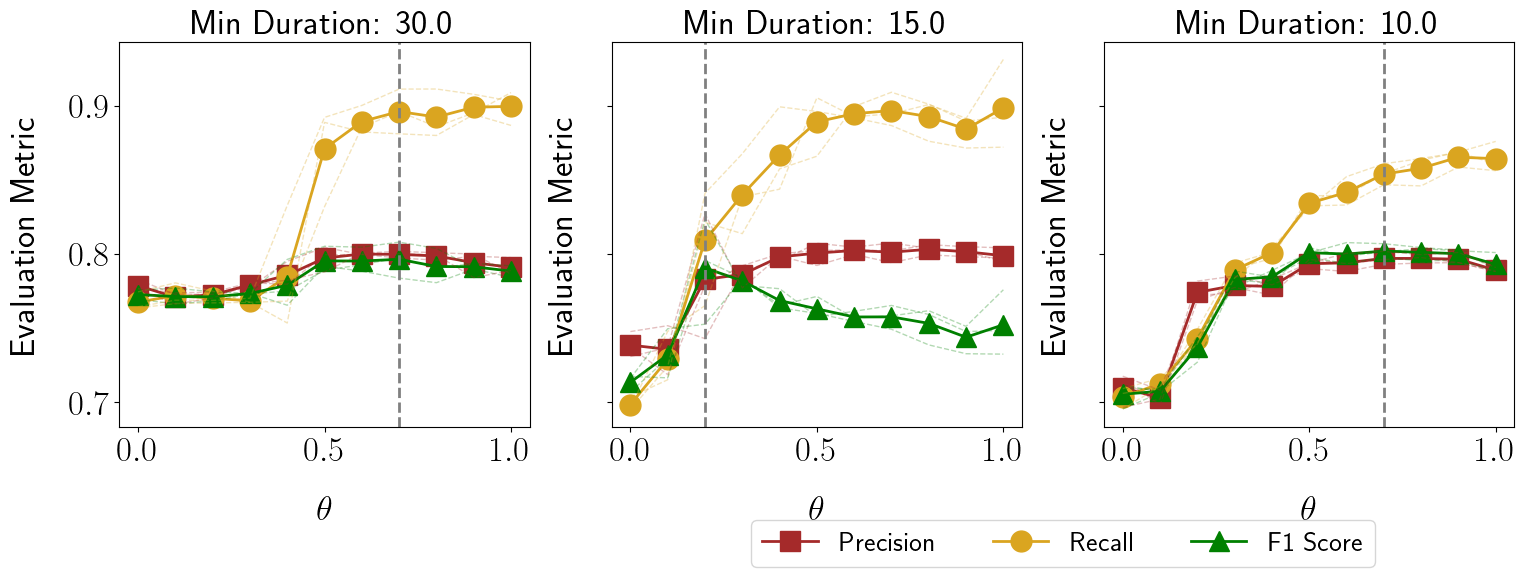

In [81]:
colors = ['brown', 'goldenrod', 'green']
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, duration in enumerate(min_windows_for_padding):
    precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

    for j, theta in enumerate(theta_list):
        for k, seed in enumerate(seed_list):

            model_dir = os.path.join(training_results_dir, f"duration{duration}_theta{theta}_seed{seed}")
            precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
            recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
            f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    axs[i].plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
    axs[i].plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
    axs[i].plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

    for k in range(len(seed_list)):
        axs[i].plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
        axs[i].plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
        axs[i].plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)

    axs[i].axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
    axs[i].set_title(f"Min Duration: {duration}")
    axs[i].set_xlabel(r'$\theta$', labelpad=20)
    axs[i].set_ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(-0.1,-0.4))
plt.show()  

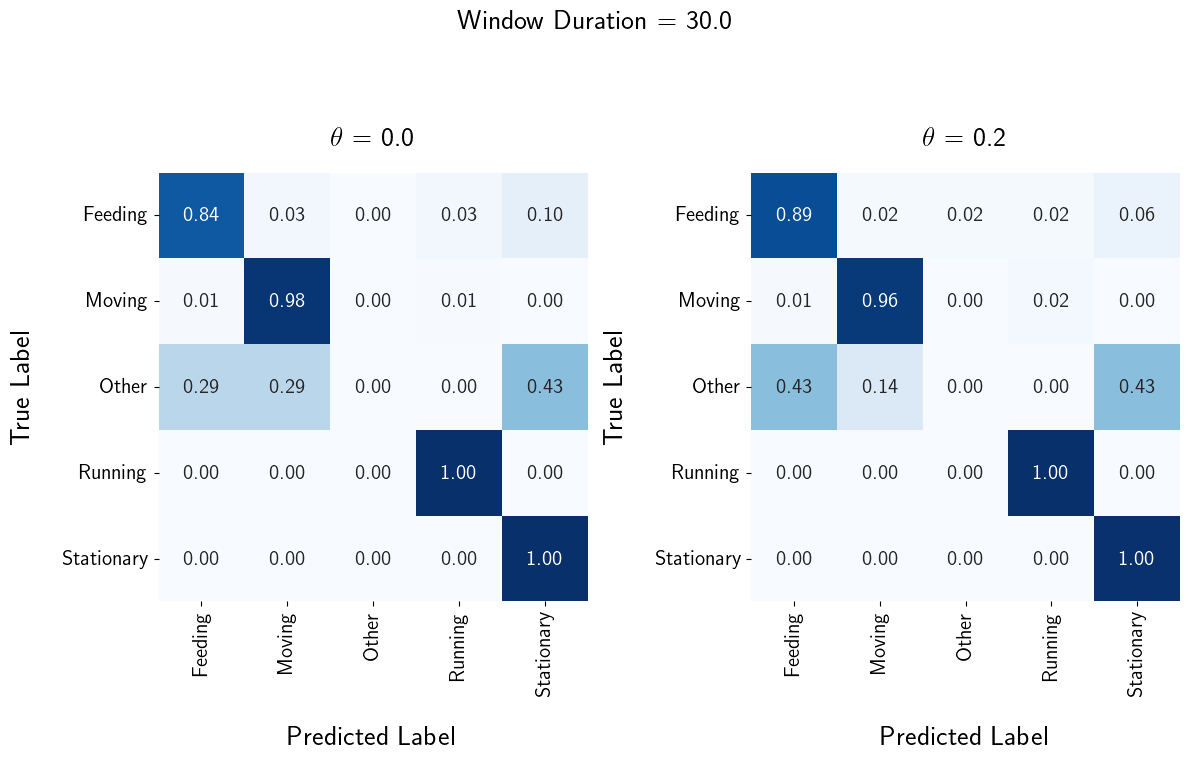

In [88]:
theta_list = [0.0, 0.2]
seed_star = 1
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{30.0}_theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {30.0}", fontsize=20)
plt.tight_layout()
plt.show()

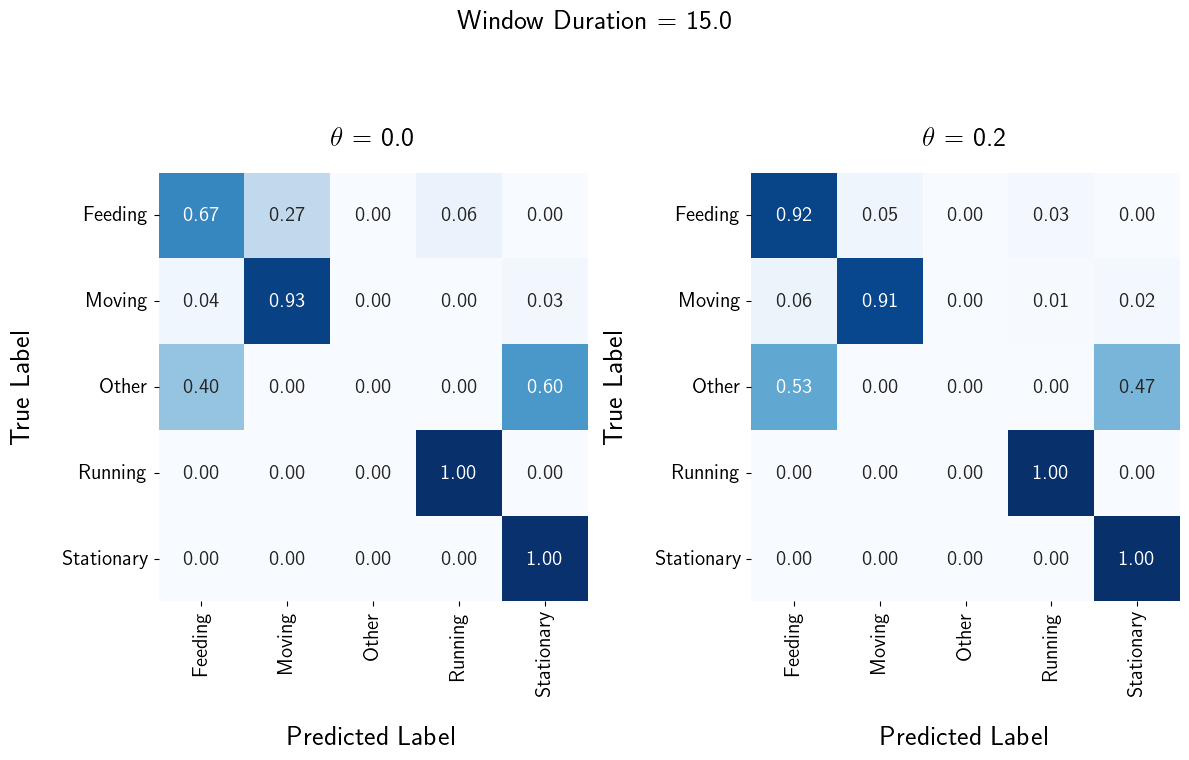

In [83]:
theta_list = [0.0, 0.2]
seed_star = 1
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{15.0}_theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {15.0}", fontsize=20)
plt.tight_layout()
plt.show()

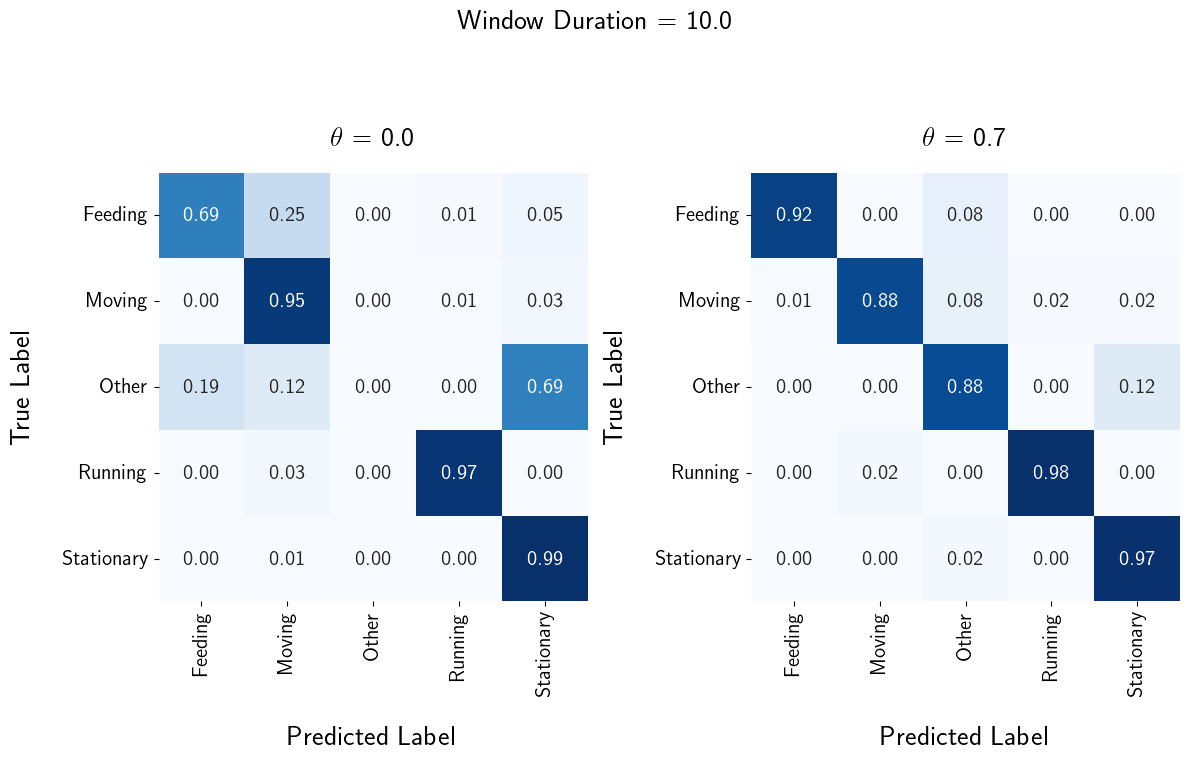

In [84]:
theta_list = [0.0, 0.7]
seed_star = 1
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{10.0}_theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {10.0}", fontsize=20)
plt.tight_layout()
plt.show()

## 3. Test the Model on Summaries on 20 seconds

In [38]:
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=20.0, sampling_rate=config.SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 20.0]
summary_acc_data_20 = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)

X = summary_acc_data_20[feature_cols].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(summary_acc_data_20['behavior'])

In [39]:
window_duration_star, theta_star = 30.0, 0.4
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}_seed{seed_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [40]:
with torch.no_grad():
    y_pred = torch.argmax(model(torch.tensor(X, dtype=torch.float32).to(device)), dim=1)

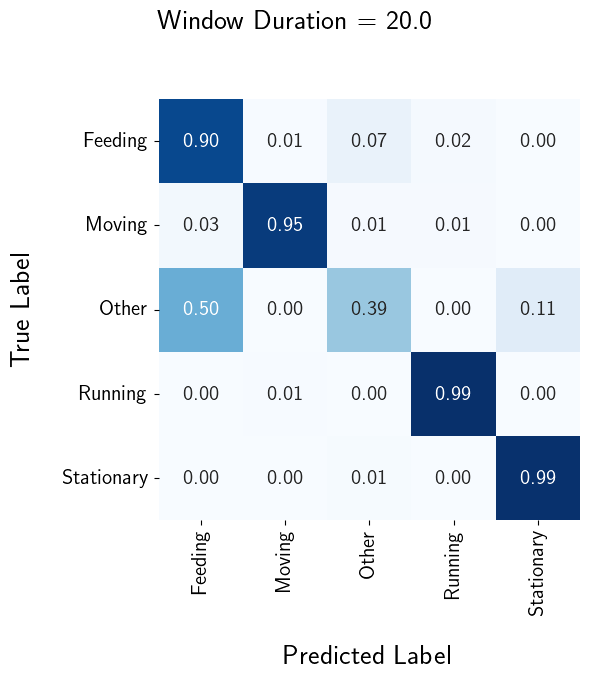

In [41]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 7))

cm = confusion_matrix(y, y_pred.detach().cpu().numpy(), normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y))))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
fig.suptitle(f"Window Duration = 20.0", fontsize=20)
plt.tight_layout()
plt.show()

## 4. Model Calibration

In [19]:
# pip install scikit-learn POT
import ot

def ot_plan(cost, a=None, b=None, reg=0.1):
    
    if a is None: a = np.full(cost.shape[0], 1.0/cost.shape[0])
    if b is None: b = np.full(cost.shape[1], 1.0/cost.shape[1])

    T = ot.sinkhorn(a, b, cost, reg=reg)
    return T, a, b

In [21]:
# load model
window_duration_star, theta_star = 30.0, 0.4
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}_seed{seed_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [22]:
with torch.no_grad():
    y_test_scores = model(torch.tensor(X_test, dtype=torch.float32).to(device))

y_test_scores = y_test_scores.cpu().numpy()
y_test_pred = np.argmax(y_test_scores, axis=1)

In [ ]:
from collections import Counter
counts_pred = Counter(y_test_pred)
counts_test = Counter(y_test)
counts_val = Counter(y_val)

total = len(y_test_pred)

print("CLASS DISTRIBUTION IN VAL DATA")
print('-'*20)
for cls, count in counts_val.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")
print("")

print("CLASS DISTRIBUTION IN TEST DATA")
print('-'*20)
for cls, count in counts_test.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")
print("")

print("PREDICTED CLASS DISTRIBUTION IN TEST DATA")
print('-'*20)
for cls, count in counts_pred.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")

CLASS DISTRIBUTION IN VAL DATA
--------------------
['Stationary']: 80.97
['Feeding']: 4.58
['Running']: 5.17
['Moving']: 9.03
['Other']: 0.26

CLASS DISTRIBUTION IN TEST DATA
--------------------
['Stationary']: 80.97
['Moving']: 9.03
['Feeding']: 4.51
['Running']: 5.23
['Other']: 0.26

PREDICTED CLASS DISTRIBUTION IN TEST DATA
--------------------
['Stationary']: 80.25
['Moving']: 8.63
['Feeding']: 4.64
['Running']: 5.30
['Other']: 1.18


In [39]:
# calibrate the predictions on test set to follow the true class distribution (on validation set)

b = np.array([counts_val[i] for i in range(len(config.SUMMARY_BEHAVIORS))])/y_val.shape[0]
T, a, b = ot_plan(1-y_test_scores, a=None, b=b, reg=0.01)
ot_pred = np.argmax(T, axis=1)

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


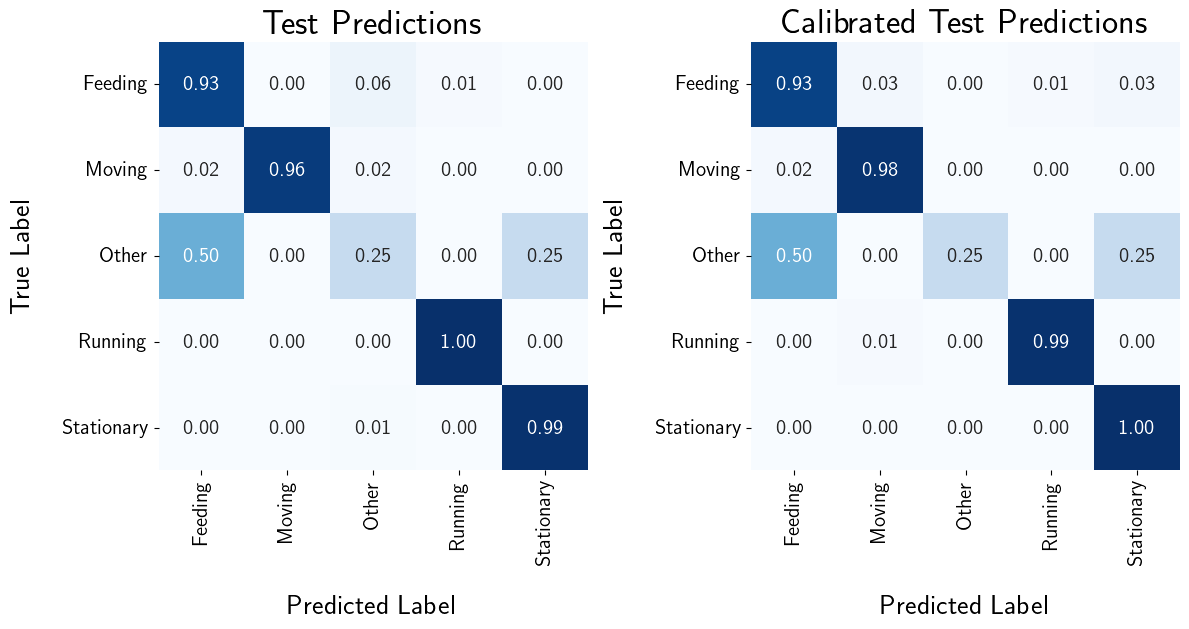

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cm = confusion_matrix(y_test, y_test_pred, normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y_test))))
ax = axes[0]
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
ax.set_title("Test Predictions")

cm = confusion_matrix(y_test, ot_pred, normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y_test))))
ax = axes[1]

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
ax.set_title("Calibrated Test Predictions")

plt.tight_layout()
plt.show()

In [ ]:
print(np.sum(y_test != ot_pred), np.sum(y_test != y_test_pred))

15 26


In [47]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 69
Moving: 138
Other: 4
Running: 80
Stationary: 1238


In [45]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test[y_test != y_test_pred]), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 5
Moving: 6
Other: 3
Stationary: 12


In [46]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test[y_test != ot_pred]), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 5
Moving: 3
Other: 3
Running: 1
Stationary: 3
